In [1]:
import os
import time
import math
import random
import shutil
import contextlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as data
import torchvision.transforms as transforms

from utils.converter import LabelConverter, IndexConverter
from datasets.dataset import InMemoryDigitsDataset, DigitsDataset, collate_train, collate_dev, inmemory_train, inmemory_dev
from generate import gen_text_img

import arguments
from models.densenet_ import DenseNet

import warnings
warnings.filterwarnings("always")

In [2]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()

    for i, sample in enumerate(train_loader):
        # Measure data loading time
        data_time.update(time.time() - end)

        # Zero out gradients so we can accumulate new ones over batches
        optimizer.zero_grad()

        # step 2. Get our inputs targets ready for the network.
        # targets is a list of `torch.IntTensor` with `batch_size` size.
        target_lengths = sample.target_lengths.to(device)
        targets = sample.targets # Expected targets to have CPU Backend

        # step 3. Run out forward pass.
        images = sample.images
        if isinstance(images, tuple):
            targets = targets.to(device)
            log_probs = []
            for image in images:
                image = image.unsqueeze(0).to(device)
                log_prob = model(image).squeeze(1)
                log_probs.append(log_prob)
            input_lengths = torch.IntTensor([i.size(0) for i in log_probs]).to(device)
            log_probs = pad_sequence(log_probs)
        else: # Batch
            images = images.to(device)
            log_probs = model(images)
#             log_probs = F.log_softmax(log_probs, dim=2)
#             log_probs = log_probs.permute(1,0,2)
            input_lengths = torch.full((images.size(0),), log_probs.size(0), dtype=torch.int32, device=device)
        # step 4. Compute the loss, gradients, and update the parameters
        # by calling optimizer.step()
        loss = criterion(log_probs, targets, input_lengths, target_lengths)
        losses.update(loss.item())
        loss.backward()

        # do one step for multiple batches
        # accumulated gradients are used
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if (i+1) % args.print_freq == 0 or i == 0 or (i+1) == len(train_loader):
            print('>> Train: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(
                   epoch+1, i+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))

    return losses.avg


In [3]:
def validate(dev_loader, model, epoch, converter):
    batch_time = AverageMeter()
    accuracy = AverageMeter()

    # switch to evaluate mode
    model.eval()

    num_correct = 0
    num_verified = 0
    end = time.time()

    #for i, (images, targets) in enumerate(dev_loader):
    for i, sample in enumerate(dev_loader):
        images = sample.images
        targets = sample.targets
        if isinstance(images, tuple):
            preds = []
            for image in images:
                image = image.unsqueeze(0).to(device)
                log_prob = model(image)
                preds.append(converter.best_path_decode(log_prob, strings=False))
        else: # Batch
            images = images.to(device)
            log_probs = model(images)
            preds = converter.best_path_decode(log_probs, strings=False)

        # measure elapsed time
#         print(log_probs)
        batch_time.update(time.time() - end)
        end = time.time()
        for i in range(len(targets)):
             num_verified += len(targets[i])
#         print(num_verified)
        for pred, target in zip(preds, targets):
            print(pred)
            print(target)
            for i in range(min(len(target),len(pred))):
                if target[i]==pred[i]:
                    num_correct += 1
#         print(num_correct)
        accuracy.update(num_correct / num_verified) # character
                
#         for i in range(len(preds)):
#             pred = converter.best_path_decode(log_probs, strings=True)[i].decode('utf-8')
#             print('pred: {}'.format(pred))

        if (i+1) % args.print_freq == 0 or i == 0 or (i+1) == len(dev_loader):
            print('>> Val: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Accu {accuracy.val:.3f}'.format(
                   epoch+1, i+1, len(dev_loader), batch_time=batch_time, accuracy=accuracy))

    return accuracy.val


In [4]:
def save_checkpoint(state, is_best, directory):
    filename = os.path.join(directory, '{}_epoch_{}.pth.tar'.format(state['arch'], state['epoch']))
    with contextlib.suppress(FileNotFoundError):
        os.remove(filename)
    torch.save(state, filename)
    if is_best:
        print('>>>> save best model at epoch: {}'.format(state['epoch']))
        filename_best = os.path.join(directory, '{}_best.pth.tar'.format(state['arch']))
        with contextlib.suppress(FileNotFoundError):
            os.remove(filename_best)
        shutil.copyfile(filename, filename_best)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def set_batchnorm_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        # freeze running mean and std:
        # we do training one image at a time
        # so the statistics would not be per batch
        # hence we choose freezing (ie using imagenet statistics)
        m.eval()
        # # freeze parameters:
        # # in fact no need to freeze scale and bias
        # # they can be learned
        # # that is why next two lines are commented
        # for p in m.parameters():
            # p.requires_grad = False

In [5]:
import sys
# alphabet/alphabet_decode_5990.txt
sys.argv = ['main.py','--dataset-root','alphabet','--arch','densenet121','--alphabet','alphabet/alphabet_decode_5990.txt',
            '--lr','5e-5','--max-epoch','20','--optimizer','sgd','--gpu-id','-1']

In [6]:
args = arguments.parse_args()

if args.gpu_id < 0:
    device = torch.device("cpu")
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True

# create export dir if it doesnt exist
directory = "{}".format(args.arch)
directory += "_{}_lr{:.1e}_wd{:.1e}".format(args.optimizer, args.lr, args.weight_decay)
directory += "_bsize{}_imsize{}".format(args.batch_size, args.image_size)

args.directory = os.path.join(args.directory, directory)
print(">> Creating directory if it does not exist:\n>> '{}'".format(args.directory))
if not os.path.exists(args.directory):
    os.makedirs(args.directory)

# initialize model
if args.pretrained:
    print(">> Using pre-trained model '{}'".format(args.arch))
else:
    print(">> Using model from scratch (random weights) '{}'".format(args.arch))

# load alphabet from file
if os.path.isfile(args.alphabet):
    alphabet = ''
    with open(args.alphabet, mode='r', encoding='utf-8') as f:
        for line in f.readlines():
            alphabet += line.strip()
    args.alphabet = alphabet

model = DenseNet(num_classes=len(args.alphabet) + 1)

if args.pretrained:
    model_path = 'pretrained/new_prarams2.pth'
    checkpoint = torch.load(model_path,map_location = 'cpu')
    model.load_state_dict(checkpoint)

transform = transforms.Compose([
    transforms.Resize((32, 280)),
    transforms.ToTensor(),
])

>> Creating directory if it does not exist:
>> './checkpoint\densenet121_sgd_lr5.0e-05_wd5.0e-04_bsize64_imsize32'
>> Using pre-trained model 'densenet121'


In [7]:
# define loss function
criterion = nn.CTCLoss()
criterion = criterion.to(device)

# define optimizer
if args.optimizer == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
elif args.optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

converter = LabelConverter(args.alphabet, ignore_case=False)

# define learning rate decay schedule
# TODO: maybe pass as argument in future implementation?
# exp_decay = math.exp(-0.1)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=exp_decay)

acc = []
losses = []
times = []
start_time = time.time()

In [8]:
from datasets.dataset import InMemoryDigitsDataset, DigitsDataset, collate_train, collate_dev, inmemory_train, inmemory_dev

num = 100
dev_num = num
use_file = 1
text = "十四二"
text_length = 2
font_size = 32
font_id = 1
space_width = 1
text_color = '#282828'
thread_count = 8
channel = 3

random_skew = True
skew_angle = 0
random_blur = True
blur = 0

orientation = 0
distorsion = 0
distorsion_orientation = 0
background = 1

random_process = False
noise = 0
erode = 0
dilate = 0
incline = 0

In [9]:
for i in range(30):
    text_meta, text_img = gen_text_img(num, use_file, text, text_length, font_size, font_id, space_width, background, text_color,
                                      orientation, blur, random_blur, distorsion, distorsion_orientation, skew_angle, random_skew,
                                      random_process, noise, erode, dilate, incline,
                                      thread_count, channel)
    #     dev_meta, dev_img = gen_text_img(dev_num, use_file, text, text_length, font_size, font_id, space_width, background, text_color,
    #                               orientation, blur, random_blur, distorsion, distorsion_orientation, skew_angle, random_skew,
    #                               thread_count)
    dev_meta, dev_img = text_meta, text_img

    index_converter = IndexConverter(args.alphabet, ignore_case=False)

    train_dataset = InMemoryDigitsDataset(mode='train',text=text_meta,img=text_img,total=num,
                                      transform=transform, converter = index_converter)
    dev_dataset = InMemoryDigitsDataset(mode='dev', text=dev_meta, img=dev_img, total=dev_num,
                                    transform=transform, converter = index_converter)

    train_loader = data.DataLoader(train_dataset, batch_size=args.batch_size, collate_fn=collate_train,
                               shuffle=True, num_workers=args.workers, pin_memory=True)
    dev_loader = data.DataLoader(dev_dataset, batch_size=args.batch_size, collate_fn=collate_dev,
                             shuffle=False, num_workers=args.workers, pin_memory=True)
    
    for i, sample in enumerate(train_loader):
        print(sample.targets.shape)
    
    is_best = False
    best_accuracy = 0.0
    accuracy = 0.0
    start_epoch = 0
    
    for epoch in range(start_epoch, args.max_epoch):
        if args.test_only:
            args.max_epoch = 1
            print('>>>> Test model, using model at epoch: {}'.format(start_epoch))
            start_epoch -= 1
            with torch.no_grad():
                accuracy = validate(dev_loader, model, start_epoch, converter)
            acc.append(format(accuracy))
            print('>>>> Accuracy: {}'.format(accuracy))
        else:
            # aujust learning rate for each epoch
#             scheduler.step()

            # train for one epoch on train set
            loss = train(train_loader, model, criterion, optimizer, epoch)
            losses.append(format(loss))
            # evaluate on validation set
            if (epoch + 1) % args.validate_interval == 0:
                with torch.no_grad():
                    accuracy = validate(dev_loader, model, epoch, converter)

            # # evaluate on test datasets every test_freq epochs
            # if (epoch + 1) % args.test_freq == 0:
            #     with torch.no_grad():
            #         test(args.test_datasets, model)

            # remember best accuracy and save checkpoint
            is_best = accuracy > 0.0 and accuracy >= best_accuracy
            best_accuracy = max(accuracy, best_accuracy)
            acc.append(format(accuracy))
            print('>>>> Accuracy: {}'.format(accuracy))

            if (epoch + 1) % args.save_interval == 0:
                save_checkpoint({
                    'arch': args.arch,
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'best_accuracy': best_accuracy,


                    'optimizer' : optimizer.state_dict(),
                }, is_best, args.directory)
            if best_accuracy == 1:
                break
    end_time = time.time()
    times.append(end_time-start_time)


KeyboardInterrupt: 

In [34]:
torch.save(model.state_dict(), 'pretrained/new_prarams2.pth')

In [ ]:
x= [i for i in range(0,len(acc))]
plt.plot(x,acc,color = 'b',label="acc")
plt.plot(x,losses,color = 'b',label="loss")

In [ ]:
record_losses=losses
record_time = times
record_acc = acc

len(times)

Text(0, 0.5, 'time for each iteration(max_epoch = 30)')

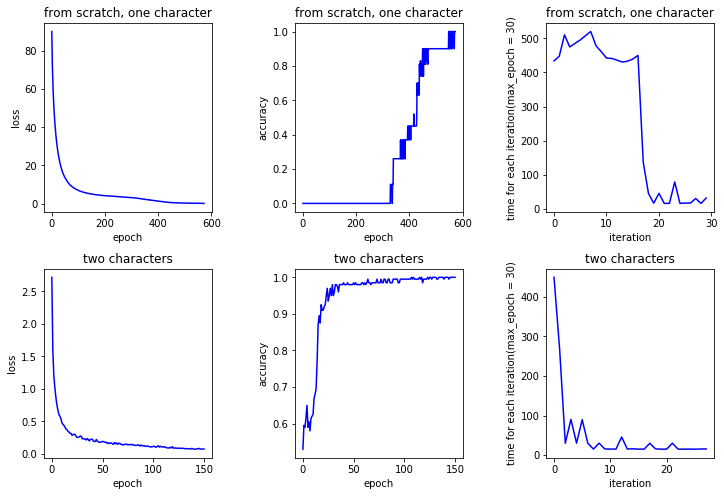

In [117]:
x= [i for i in range(0,len(acc[:573]))]
y = [i for i in range(0,len(acc[573:len(acc)-1]))]
record_l = [round(float(losses[i]),4) for i in range(len(losses))]
record_a = [round(float(acc[i]),3) for i in range(len(acc))]
x_ = [i for i in range(0,30)]
y_ = [i for i in range(0,28)]
interval = [times[i+1]-times[i] for i in range(30)]
interval_2 = [times[i+1]-times[i] for i in range(34,len(times)-1)]
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,8))
axes.flatten()
plt.subplots_adjust(wspace = 0.5,hspace = 0.3)
axes[0][0].plot(x,record_l[:573],color = 'b',label="loss")
axes[0][0].set_title("from scratch, one character")
axes[0][0].set_xlabel("epoch")
axes[0][0].set_ylabel("loss")
axes[0][1].plot(x,record_a[:573], color = 'b',label="acc")
axes[0][1].set_title("from scratch, one character")
axes[0][1].set_xlabel("epoch")
axes[0][1].set_ylabel("accuracy")
axes[0][2].plot(x_,interval, color = 'b',label="time")
axes[0][2].set_title("from scratch, one character")
axes[0][2].set_xlabel("iteration")
axes[0][2].set_ylabel("time for each iteration(max_epoch = 30)")

axes[1][0].plot(y,record_l[573:len(acc)-1],color = 'b',label="loss")
axes[1][0].set_title("two characters")
axes[1][0].set_xlabel("epoch")
axes[1][0].set_ylabel("loss")
axes[1][1].plot(y,record_a[573:len(acc)-1],color = 'b',label="loss")
axes[1][1].set_title("two characters")
axes[1][1].set_xlabel("epoch")
axes[1][1].set_ylabel("accuracy")
axes[1][2].plot(y_,interval_2, color = 'b',label="time")
axes[1][2].set_title("two characters")
axes[1][2].set_xlabel("iteration")
axes[1][2].set_ylabel("time for each iteration(max_epoch = 30)")

In [ ]:
# params = list(model.parameters())
# k = 0
# count = 0
# for i in params:
#     print('第',count,"层：")
#     l = 1
#     print("该层的结构：" + str(list(i.size())))
#     for j in i.size():
#         l *= j
#     print("该层参数和：" + str(l))
#     k = k + l
#     count = count+1


In [18]:
import random
text = "一二三四五五六七八九十"
temp = ""
for i in range(4000):
    temp +=text[random.randint(0,9)]

In [19]:
temp


'一二八五三五三三八七二一九三五七三三四四七三八四八四六二五一一八六九九四六三六七二九八四七九六二五八七五七三七四三五五三八五九一二四五七一一二一九三五二八一三三二六七五四一五一七七三一一六五五一八五五一五六七三三七七七五八五一九二九四五九四三五四六二三四八四四八八四三二四六六七六一四五四五六七六八五六七六五一三二四三三五一四三三七九五五三三五三六二四七八八七一八三九三七七九三四二三八二五五五六四四五九一八二七五七一一二五三五六三七一九六二四四二五三五九一七一九七五一七六六九三八二九二八一六七五九六五五一七三一七五五五五二六四五二二五八八八五五三二三六四五五四九九九三六二二八三二二三三三八九二六四五五八八七四八九五五四六一一四五三五五六五五五八一五一八三五一八四六五七四五二二九六一一四一六八六七五三五四四七七六四一九三九五四六五九二七八二三二二九九一七三五二六八六八五五九九九五四七八三五四九四四四八五九八五三六五四三八一三一六二五二三八五八九五七三五五五二九四五二九四四八五九三五八五六一二八五七四八六五六五二四四六三七二一三五一五四四五七四五一三二六三七九九七四二五五八六二七一四五三五四八八七六九三二四二七四三九八五五八七五九四三一九九二八五七五九九六四九三二四五七九一二四六九四五三四五八五二三一七一五四三六五二二四五六一二五五八八五五七四八五七七一七九四二二二八五一九三五五三八四一四七四九一三九九五五一一八一九二五九五六七三四四三五三九六五七六五七八五八五九六三四八五一七六七二七三八五五八六五七八一一五九四二七五四六五九三五二二二七三五六二九七五六七五八六一一二五七九四七三九七九八一六九一一一二五四六三五二五一五八八五五三四一五五五八四五六四九一四六九五七二九五二四二四五一二五五九三一九四六三六五一一七七八九一一九五四五七九九八八五四九七七八一九五七七八八三六二五二一五三五三二五六五八八六九三七八七八八五五五二三三一五八二七六四四二九八五七九九五七六八八九五七一一三五九一五六八九七二四六七九九三二五六八八六九七八七五一六九五六六七四四六五七四一七八六九二三四一四九四四四二七三五七二四九六二三八五四四五三三四三六四六三九三六九二二一二九六八四六二七七八四五七七二二五五六三六七九二四三七一五二三六五三六九五五一八六八六七九一六五五四一九四九八五六一九三八七三三二六五五